In [1]:
import albumentations as A
import torch
import json
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
import glob
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from pywget import wget
from dataloaders import BalloonDatasetSegmentation

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Create masks

In [3]:
# link = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
# wget.download(link)

In [4]:
# !unzip balloon_dataset.zip

In [5]:
def create_labels(dataset_type='train'):
    f = open(f'balloon\\{dataset_type}\\via_region_data.json')
    json_file = json.load(f)
    for file in json_file:
        path = f'balloon\\{dataset_type}'
        filename = json_file[file]['filename']

        path_to_mask = f"{path}\\masks\\{filename.replace('.jpg', '.png')}"

        if os.path.exists(path_to_mask):
            continue
        else:                
            img = cv2.imread(f'{path}\\{filename}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            regions = json_file[file]['regions']
            label = np.zeros_like(img)

            for n in regions:
                mask = np.zeros((img.shape[0], img.shape[1]))
                x_coords = regions[n]['shape_attributes']['all_points_x']
                y_coords = regions[n]['shape_attributes']['all_points_y']
                coords_of_polygon = np.dstack((x_coords, y_coords))
                cv2.fillConvexPoly(mask, coords_of_polygon, 1)
                mask = mask.astype(bool)
                label[mask] = 1
            cv2.imwrite(path_to_mask, label)

In [6]:
create_labels('train')
create_labels('val')

## Utils

In [7]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)


def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
def compare_predictions(loaders, model):
    n = np.random.choice(len(loaders.test_dataset))

    image, gt_mask = loaders.test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)

    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image.transpose(1, 2, 0), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

## Augmentations

In [8]:
def minimal_augmentation():
    transform = [
        A.Resize(height=512, width=512, p=1)]
    return A.Compose(transform)

def get_training_augmentation():
    train_transform = [
        A.Resize(height=512, width=512, p=1),
        
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [9]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [10]:
class My_network():
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
        )
        
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):

            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)

            if i%10==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 2))
                print(round(valid_logs['iou_score'] , 2))

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)

In [14]:
class BalloonLoaders():
    def __init__(self, augmentation):
        self.balloon_dataset = BalloonDatasetSegmentation('balloon\\train', 
                                                 classes=['balloon'], 
                                                 preprocessing=get_preprocessing(preprocessing_fn),
                                                 augmentation=augmentation,)

        self.valid_dataset = BalloonDatasetSegmentation('balloon\\val',
                                                   classes=['balloon'],
                                                   preprocessing=get_preprocessing(preprocessing_fn),
                                                   augmentation=minimal_augmentation(),)

        self.train_size = int(0.8 * len(self.balloon_dataset))
        self.test_size = len(self.balloon_dataset) - self.train_size

        self.train_dataset, self.test_dataset = torch.utils.data.random_split(self.balloon_dataset, 
                                                                              [self.train_size, self.test_size])

        self.train_loader = DataLoader(self.train_dataset, batch_size=8, shuffle=True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size=8, shuffle=False)
    def show_example(self):
        n = np.random.choice(len(self.train_dataset))
        image, mask = self.train_dataset[n]
        visualize(image=image.transpose((1, 2, 0)), mask=mask.transpose((1, 2, 0))*255)

In [15]:
network = My_network(loss, metrics)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


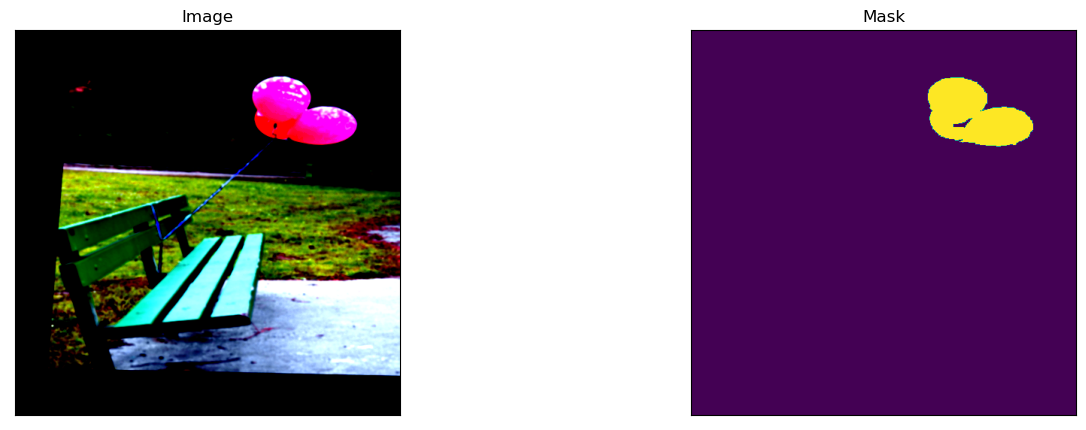

In [16]:
balloon_loaders = BalloonLoaders(augmentation=get_training_augmentation())
balloon_loaders.show_example()

In [17]:
network.run_training(balloon_loaders)

==Epoch 0==
Train/Val IoU:
0.16
0.13
==Epoch 10==
Train/Val IoU:
0.71
0.56
==Epoch 20==
Train/Val IoU:
0.66
0.68
==Epoch 30==
Train/Val IoU:
0.65
0.84


In [18]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [19]:
test_dataloader = DataLoader(balloon_loaders.test_dataset)
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 13/13 [00:00<00:00, 13.92it/s, dice_loss - 0.3619, iou_score - 0.7777]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


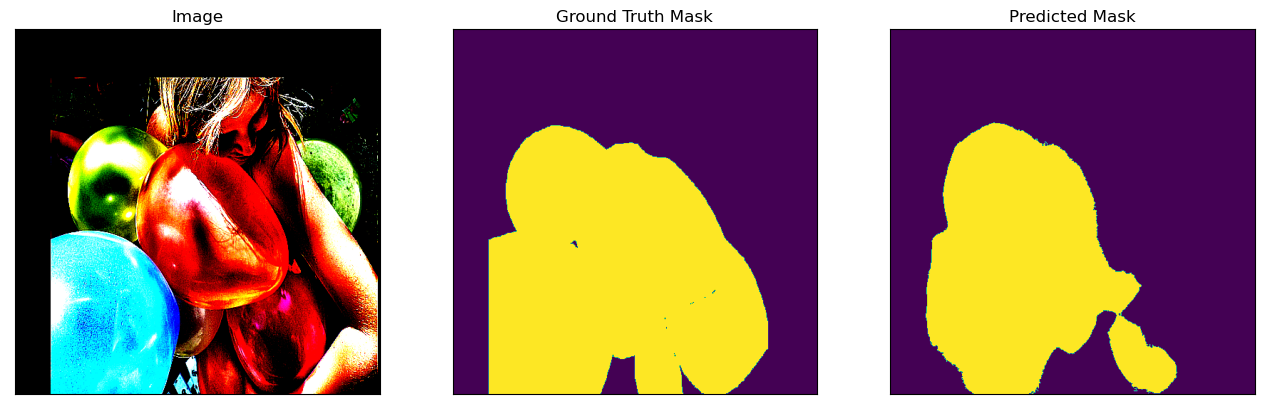

In [20]:
compare_predictions(balloon_loaders, best_model)

## Without augmentations

In [21]:
network_without_aug = My_network(loss, metrics)
balloon_loaders = BalloonLoaders(augmentation=minimal_augmentation())
network_without_aug.run_training(balloon_loaders, save_name='./best_model_without_aug.pth')

==Epoch 0==
Train/Val IoU:
0.2
0.2
==Epoch 10==
Train/Val IoU:
0.79
0.75
==Epoch 20==
Train/Val IoU:
0.88
0.87
==Epoch 30==
Train/Val IoU:
0.94
0.88


In [22]:
# load best saved checkpoint
best_model = torch.load('./best_model_without_aug.pth')

In [23]:
test_dataloader = DataLoader(balloon_loaders.test_dataset)
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 13/13 [00:00<00:00, 20.44it/s, dice_loss - 0.3461, iou_score - 0.7815]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


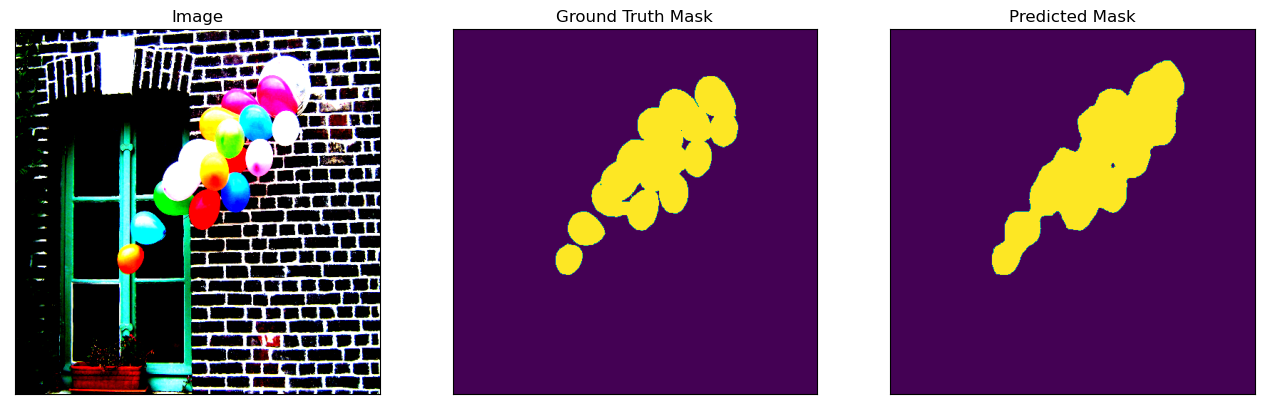

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


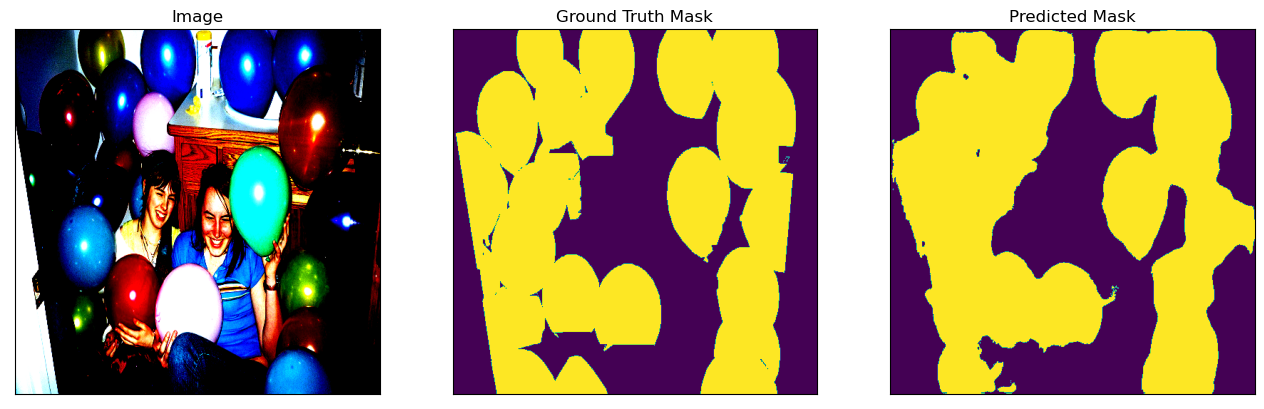

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


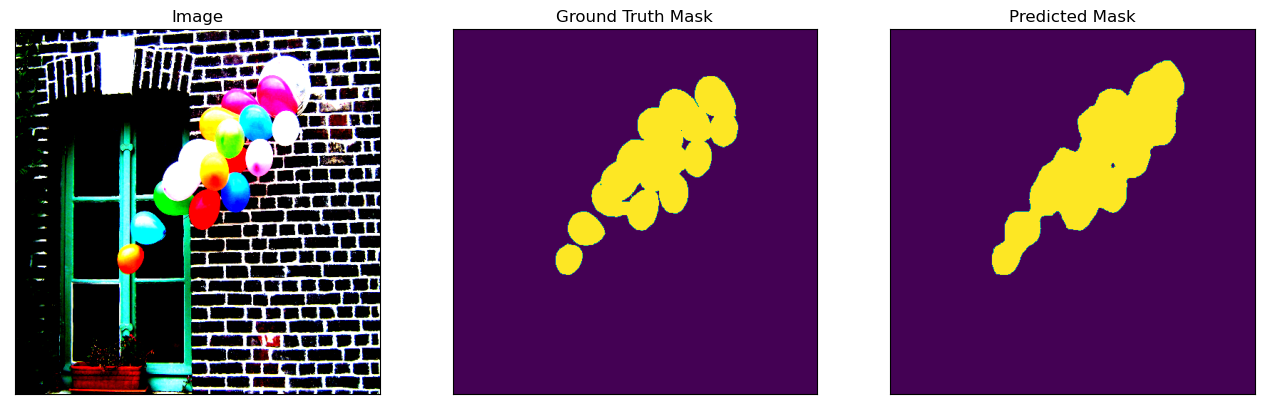

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


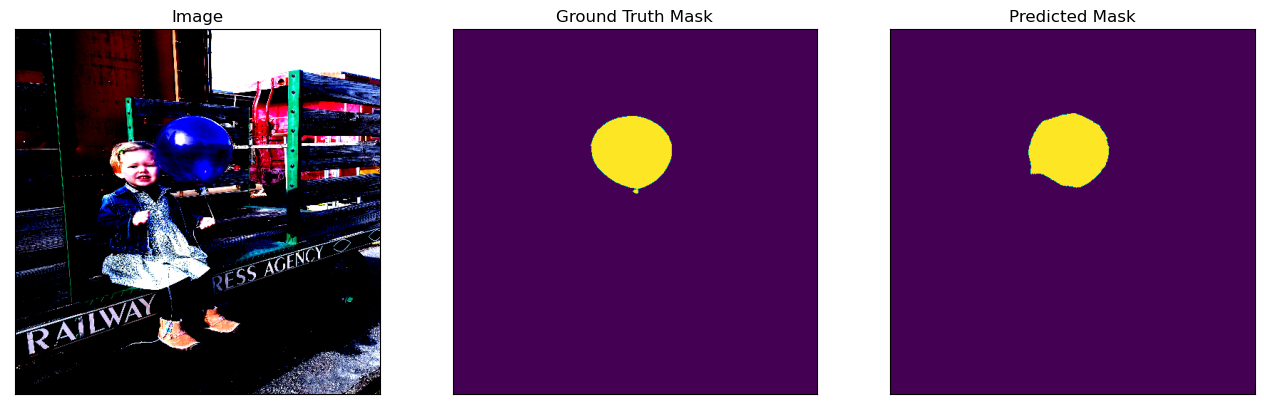

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


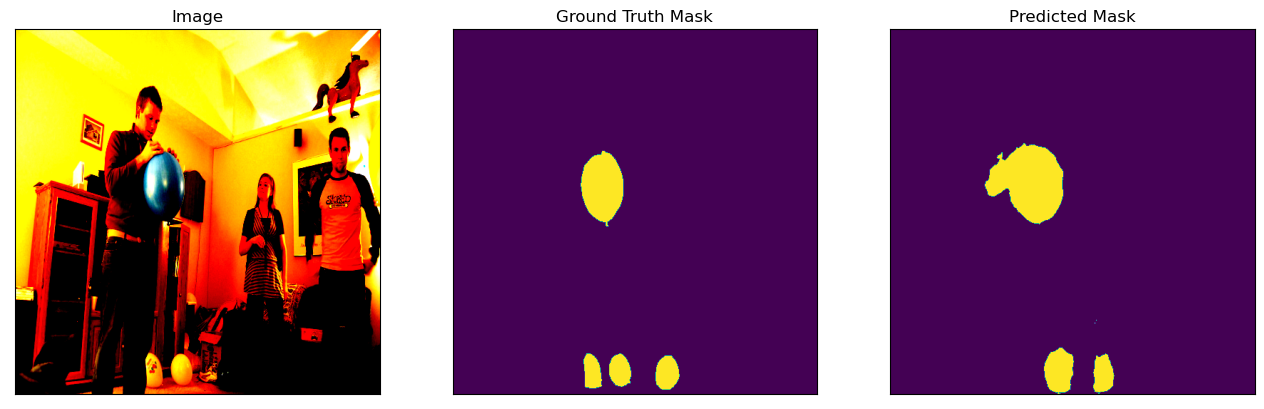

In [25]:
for _ in range(5):
    compare_predictions(balloon_loaders, best_model)